# 6.5.1 검증 데이터
- 훈련 데이터 : 매개변수 학습
- 검증 데이터 : 하이퍼 파라미터 성능 평가
- 시험 데이터 : 신경망의 범용 성능 평가

In [10]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from deep_learning_github.dataset.mnist import load_mnist
from deep_learning_github.common.multi_layer_net import MultiLayerNet
from deep_learning_github.common.optimizer import SGD
from deep_learning_github.common.util import * 

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

print(x_train.shape[0])
print(x_train.ndim)
print(x_train)

# 훈련 데이터를 뒤섞는다.
x_train, t_train = shuffle_dataset(x_train, t_train)

validation_rate = 0.2
validation_num = int(x_train.shape[0] * validation_rate)

print(validation_num)
x_val = x_train[: validation_num]
t_val = t_train[: validation_num]
x_train = x_train[validation_num: ]
t_train = t_train[validation_num: ]

60000
2
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
12000
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [2]:
permutation = np.random.permutation(x_train.shape[0])
permutation

array([37428,  9521, 38305, ..., 13490, 17436, 45607])

In [3]:
x = np.array([[1,2],[3,4]])
x.ndim

2

In [4]:
x = np.array([[[1,2],[3,4]]])
x.ndim
x[0,:,:,:]

IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

In [5]:
x = x_train[permutation, :]
print(len(x))

60000


In [33]:
weight_decay = 10 ** np.random.uniform(-8, -4)
weight_decay

1.4005807146917924e-08

# 6.5.3 하이퍼파라미터 최적화 구현하기

val acc:0.08 | lr:0.0002257994803480783, weight decay:2.2678166306685903e-06
val acc:0.13 | lr:0.0003124442928532459, weight decay:2.4860377859995215e-06
val acc:0.02 | lr:1.101934233521026e-06, weight decay:4.9473683109146004e-08
val acc:0.11 | lr:9.494322648626337e-05, weight decay:3.307036165743561e-07
val acc:0.1 | lr:0.00047273937678192225, weight decay:3.012012922603584e-08
val acc:0.06 | lr:6.248337185037501e-06, weight decay:8.10660812544481e-06
val acc:0.44 | lr:0.0015727068793763182, weight decay:8.114114090976169e-06
val acc:0.03 | lr:3.383995827249713e-06, weight decay:1.0813938214757971e-08
val acc:0.13 | lr:1.8466245723717614e-05, weight decay:1.0947812110963767e-07
val acc:0.21 | lr:0.00106993675473246, weight decay:5.5273819899342725e-08
val acc:0.05 | lr:0.00021987082522035518, weight decay:3.924566979734882e-06
val acc:0.15 | lr:1.870913489113125e-05, weight decay:2.1179757087137684e-07
val acc:0.4 | lr:0.0029714959675436908, weight decay:2.4862926441219226e-06
val ac

Best-18(val acc:0.27) | lr:0.002117688394419016, weight decay:3.60781856828849e-05
Best-19(val acc:0.25) | lr:0.0009153845051583338, weight decay:3.7816264637263204e-07
Best-20(val acc:0.25) | lr:0.00018454428464503568, weight decay:5.15595924849186e-08


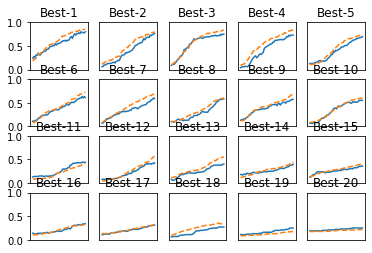

In [34]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from deep_learning_github.dataset.mnist import load_mnist
from deep_learning_github.common.multi_layer_net import MultiLayerNet
from deep_learning_github.common.util import shuffle_dataset
from deep_learning_github.common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 결과를 빠르게 얻기 위해 훈련 데이터를 줄임
x_train = x_train[:500]
t_train = t_train[:500]

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# 하이퍼파라미터 무작위 탐색======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 탐색한 하이퍼파라미터의 범위 지정===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# 그래프 그리기========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()
